# Data Sharing Method for Non-IID Settings

## Introduction

This notebook demonstrates the use of the Data Sharing approach for solving the accuracy issues that arise from a non-iid distribution of the data over clients in a federated learning setting. We implement the methods as introduced in the paper, [Federated Learning with Non-IID data](https://arxiv.org/abs/1806.00582). 

### Outline of the notebook
1. Partitioning functions to create the different FL settings (iid, non-iid, non-iid + data sharing)
2. Flower framework code
3. Experiments
4. Conclusion

## Model and Data

In order to compare the performance of the different data distributions, we will use a CIFAR-10 classifier. With CIFAR-10, we have 50,000 training images and 10,000 test. Throughout the experiments, we consider 10 clients, that will all be selected in the training, i.e. a client fraction of 1. In the IID setting, the training labels are distributed randomly and uniformly over the clients so that each client has the same distribution of labels. In the Non-IID setting, we give split the data into 20 partitions and then give each client 2 partitions from 2 labels. 

In the Data Sharing setting, we take 10,000 of the training images as a "global" dataset. To simulate the data sharing, to each client with 2 labels, we give a random 5% of the global dataset. In this way each client will be exposed to labels it hadn't seen. 

All training is done on 50 communication rounds with 10 local epochs on each client.

In [2]:
import os
import sys
from collections import OrderedDict
from typing import List, Tuple
import logging
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import Counter
from datetime import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
from flwr.client import NumPyClient, Client, ClientApp
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.server import ServerAppComponents, ServerConfig, ServerApp
from flwr.simulation import run_simulation, start_simulation

from flwr.common import (
    Metrics,
    FitIns,
    FitRes,
    EvaluateIns,
    EvaluateRes,
    Parameters,
    Scalar,
    Context,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

from model import SimpleNet, SmallCNN, BiggerCNN, Net, CNN

# Turn off the [INFO] Logs from displaying
logging.disable(sys.maxsize)

## Functions we need

We begin by defining some functions that will be necessary for partitioning the data efficiently for the various experiments as described in the introduction.

We use 2 functions: 
- `get_partitions` : creates the non-idd partitions. If `datasharing` is toggled to `True` then we add to each client a small number of each label from a global data set
- `partition_iid` :  partitions the training data uniformly across all clients following a normal distribution so that the clients data distributions are i.i.d.

In [3]:
def get_partitions(full_dataset, num_clients = 10, datasharing = True, labels_per_client = 2, seed = 42, QC = False):
    """
    Helper function for creating non-idd partitions. 
    Create 2-class non-iid partitions and toggle between datasharing on or off. 

    Args:
        - full_dataset: datasets obj., training set used in the Federated Learning simulation
        - num_clients : int, Number of clients that we are partitioning the dataset over
        - datasharing : bool, Whether we perform data sharing or keep the data pure non-iid
        - labels_per_client : int, number of labels that each client has in its training set 
        - seed : int, random seed used in random partitioning
        - QC : bool, toggle True or False whether we want to display the data in each class

    Returns: 
        - client_subsets : list of Subset objects containing the subsets of the inital datasets for each client
    """
    random.seed(seed) #? Set random seed
    total_indices = list(range(len(full_dataset))) #* Create indices for the full train set
    random.shuffle(total_indices) #* shuffle the indices around before splitting between global and base

    global_indices = total_indices[:10000] #* The Global training set corresponding to the first 10000 indices
    base_indices = total_indices[10000:] #* The base training set to be distributed over the clients


    base_indices.sort(key=lambda i: full_dataset.targets[i]) #* Sort the base indices by class label


    n_shards = num_clients*labels_per_client #* Determine the number of shards needed
    shard_size = len(base_indices) // n_shards #* Determine the size of each shard
    shards = [base_indices[i*shard_size:(i+1)*shard_size] for i in range(n_shards)] #* create a list containing the indices of all the shards


    #? Initialize variables
    clients = []
    available_shards = list(range(n_shards))


    random.shuffle(available_shards) 


    for _ in range(num_clients):
        shard_ids = [available_shards.pop(), available_shards.pop()] #* remove the last two indices in available_shards
        shard_indices = shards[shard_ids[0]] + shards[shard_ids[1]] #* get the dataset indices for the two shards
        clients.append(shard_indices) #* add the shard indices to that client

    #* if Quality Control is toggled on, then we can see the partitioning of the clients
    if QC:
        print("\nLabel distribution per client (before adding global):")
        for i, client_indices in enumerate(clients):
            labels = [full_dataset.targets[idx] for idx in client_indices]
            counts = Counter(labels)
            print(f"Client {i}: {counts}")


    #* If we are datasharing, then add some indices from the global to each client (5%)
    if datasharing:
        global_sample_size = int(len(global_indices) * 0.05)  # 500
        for i in range(len(clients)):
            extra = random.sample(global_indices, global_sample_size)
            clients[i] += extra

        #* If QC on, verify that now we have the same labels per client as before only now with some examples of other classes.
        if QC:
            print("\nLabel distribution per client (after adding global):")
            for i, client_indices in enumerate(clients):
                labels = [full_dataset.targets[idx] for idx in client_indices]
                counts = Counter(labels)
                print(f"Client {i}: {counts}")

    #* Create subset objects from the data indices of each client
    client_subsets = [Subset(full_dataset, indices) for indices in clients]

    return client_subsets

def partition_iid(trainset, num_clients, seed=42):
    """
    Function to partition the data i.i.d over the clients.

    Args:
        - trainset : datasets obj, training set used in the Federated Learning simulation
        - num_clients : int, number of clients in the simulation
        - seed : int, random seed for np.random.seed
    
    Returns: 
        - client_subsets : list of Subsets of the trainset that represent each client
    """
    np.random.seed(seed)
    indices = np.random.permutation(len(trainset)) #* shuffle the data according to a normal distribution

    client_subsets = [Subset(trainset, idx) for idx in np.array_split(indices, num_clients)] #* create the subset objects 

    return client_subsets

## Flower Setup for running simulations

As in previous workbooks, we use the Flower Framework to facilitate running the federated learning simulations. Please refer to Notebook *2_FlowerFederatedLearning.ipynb* and the [flower framework](https://flower.ai/docs/framework/index.html) website for more details. Here we wrap the setup for a Flower experiment into a function to which we pass a configuration dictionary. This allows us to run experiments while changing the hyperparameters quickly.

In [6]:
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

def run_experiment(config):

    run_accuracy = []

    backend_config = {}

    def load_datasets(partition_id, num_partitions, partition_strategy="iid"):
        """
        Load datasets function

        Args :
            - partition_id : which partition the dataloader is for, determined by Flower Context.node_config
            - num_partitions : the number of partitions (clients) to be created
            - partition_strategy : which method of partitioning to be used (iid, datasharing, no-datasharing)

        Returns 
            - trainloader : Dataloader object for the training data of the client
            - valloader : Dataloader object for the validation
            - testloader : Dataloader object for the test set
        """
        #* Define the transforms for the data
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        full_dataset = datasets.CIFAR10(root='data/cifar', train=True, download=True, transform = transform) #^ Training set
        testset = datasets.CIFAR10(root='data/cifar', train=False, download=True, transform = transform) #^ Test set
        
        #* Based on passed data partitioning approach, get the partitions
        if partition_strategy == "no-datasharing":
            partitions = get_partitions(full_dataset, num_partitions, datasharing=False, labels_per_client=config["LABELS_PER_CLIENT"], seed = config["PARTITION_SEED"], QC = False)
        
        elif partition_strategy == "datasharing":
            partitions = get_partitions(full_dataset, num_partitions, datasharing=True, labels_per_client=config["LABELS_PER_CLIENT"], seed = config["PARTITION_SEED"], QC = False)
        
        elif partition_strategy == "iid":
            partitions = partition_iid(full_dataset, num_clients=config["TOTAL_CLIENTS"], seed=config["PARTITION_SEED"])

        #* Get the corresponding partition for the client
        client_subset = partitions[partition_id]
        num_samples = len(client_subset) 
        indices = np.arange(num_samples)
        np.random.shuffle(indices) #* shuffle the indices 

        #* Create train/test split
        split = int(0.8 * num_samples)
        train_indices, val_indices = indices[:split], indices[split:]

        #* Define the dataloader for training, validation and testing
        trainloader = DataLoader(Subset(client_subset, train_indices), batch_size=config["BATCH_SIZE"], shuffle=True)
        valloader = DataLoader(Subset(client_subset, val_indices), batch_size=config["BATCH_SIZE"], shuffle=False)
        testloader = DataLoader(testset, batch_size=config["BATCH_SIZE"], shuffle=False)

        return trainloader, valloader, testloader

    def train(net, trainloader, epochs: int):
        """ Train the network on the training set. """
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=config["LR"])
        net.train()

        for epoch in range(epochs):
            correct, total, epoch_loss = 0, 0, 0.0
            for images, labels in trainloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

            epoch_loss /= len(trainloader)
            epoch_acc = correct / total
            if epoch + 1 % 25 == 0:
                print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

    def test(net, testloader):
        """ Evaluate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        correct, total, loss = 0, 0, 0.0
        net.eval()

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        loss /= len(testloader)
        accuracy = correct / total
        return loss, accuracy

    def set_parameters(net, parameters):
        for param, new_val in zip(net.parameters(), parameters):
            param.data = torch.tensor(new_val).to(param.device)

    def get_parameters(net) -> List[np.ndarray]:
        return [val.cpu().detach().numpy() for val in net.parameters()]


    #* Define FlowerClient for running the simulation
    class FlowerClient(NumPyClient):
        def __init__(self, net, trainloader, valloader):
            self.net = net
            self.trainloader = trainloader
            self.valloader = valloader
        
        def get_parameters(self, config):
            return get_parameters(self.net)

        def fit(self, parameters, config):
            set_parameters(self.net, parameters)
            train(self.net, self.trainloader, epochs=1)
            return get_parameters(self.net), len(self.trainloader), {}

        def evaluate(self, parameters, config):
            set_parameters(self.net, parameters)
            loss, accuracy = test(self.net, self.valloader)
            return float(loss), len(self.valloader), {"accuracy" : float(accuracy)}

    def client_fn(context : Context) -> Client:

        #^ Different networks i was testing
        # net = Net().to(DEVICE)
        net = CNN().to(DEVICE)

        #* Get the partition-id from Flower's node_config and load_datasets for the client
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = load_datasets(partition_id=partition_id, num_partitions=config["TOTAL_CLIENTS"], partition_strategy = config["PARTITION_STRATEGY"])
        
        return FlowerClient(net, trainloader, valloader).to_client()

    #* Function for the Flower strategy for getting a weighted average when evaluating
    def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
        """
        Function to compute the weighted average based on the number of examples.
        """
        accuracies = [num_examples*m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        run_accuracy.append(sum(accuracies)/sum(examples)) #* Append the weighted accuracy to the run_accuracy list for saving
        return {"accuracy" : sum(accuracies) / sum(examples)}


    #* The flower server function
    def server_fn(context : Context) -> ServerAppComponents:
        config_server = ServerConfig(num_rounds=config["ROUNDS"])

        #* Initialize the FedAvg strategy to be used in the simulation
        strategy = FedAvg(
            fraction_fit = 1.0, # Fraction of clients
            fraction_evaluate = 0.5, # Fraction of clients to evaluate on
            min_fit_clients = 10, # Minimum number of clients to use each round
            min_evaluate_clients=5, # Minimum number of clients to use for evaluation
            min_available_clients = 10, # minimum number of clients that need to be available
            evaluate_metrics_aggregation_fn=weighted_average, # Pass in weighted average function
        )

        return ServerAppComponents(strategy=strategy, config=config_server)

    client = ClientApp(client_fn = client_fn) #* Create ClientApp

    server = ServerApp(server_fn = server_fn) #* Create ServerApp 

    start = datetime.now()
    print(f'Starting training at {start.strftime('%H:%M:%S')}')

    #* Run simulation
    history = run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=config["TOTAL_CLIENTS"],
        backend_config=backend_config
    )

    end = datetime.now()
    print(f'Finished at {end.strftime('%H:%M:%S')}')

    #* Code to save results if needed
    # run_end_time = datetime.now().strftime('%Y-%m-%d_%H%M%S')
    # with open(f'outputs/train_{run_end_time}_rounds_{config["ROUNDS"]}_{config["PARTITION_STRATEGY"]}_Net.pkl', 'wb') as f:
    #     pickle.dump(run_accuracy, f)
    
    if config["plot"]:
        data = np.array(run_accuracy)*100
        plt.plot(data)
        plt.title(f"{round(run_accuracy[-1]*100, 1)}%, {config["ROUNDS"]} comm. rounds, 5% {config["PARTITION_STRATEGY"]}")
        plt.xlabel("Communcation Rounds")
        plt.ylabel("Class. Accuracy")
        plt.show()

    

    return run_accuracy


## Experiments

With the code setup, we run three different experiments to test the performance of the datasharing approach
1. IID Data over clients
2. Non-IID over clients
3. Non-IID with 5% global dataset shared to clients

In [5]:
 #* Define the Configuration of the experiment with datasharing
config_1 = {
    "TOTAL_CLIENTS" : 10,      # Number of clients
    "CLIENTS_PER_ROUND" : 10,  # Number of clients per round Equal to C : 1
    "ROUNDS" : 50,             # Number of rounds
    "LOCAL_EPOCHS" : 10,       # Number of local epochs
    "EPOCHS" : 10,             # Number of epochs
    "BATCH_SIZE" : 64,         # Batch size
    "PARTITION_SEED" : 42,     # Seed for partitioning the dataset
    "LR" : 0.001,              # Learning rate
    "LABELS_PER_CLIENT" : 2,   # Number of labels per client (for pathological data partitioning)
    "PARTITION_STRATEGY" : "iid", # partition strategy
    "plot" : False,
}

run_accuracy_1 = run_experiment(config_1)

Starting training at : 11:05:23
Finished at 11:11:35


In [7]:
 #* Configuration for no datasharing to non-iid distributed data over clients
config_2 = {
    "TOTAL_CLIENTS" : 10,      # Number of clients
    "CLIENTS_PER_ROUND" : 10,  # Number of clients per round Equal to C : 1
    "ROUNDS" : 50,             # Number of rounds
    "LOCAL_EPOCHS" : 10,       # Number of local epochs
    "EPOCHS" : 10,             # Number of epochs
    "BATCH_SIZE" : 64,         # Batch size
    "PARTITION_SEED" : 42,     # Seed for partitioning the dataset
    "LR" : 0.001,              # Learning rate
    "LABELS_PER_CLIENT" : 2,   # Number of labels per client (for pathological data partitioning)
    "PARTITION_STRATEGY" : "no-datasharing", # partitioning strategy
    "plot" : False,
}

run_accuracy_2 = run_experiment(config_2)

Starting training at 11:13:24
Finished at 11:22:09


In [8]:
 #* Configuration settings for data sharing setting with 5% global data shared
config_3 = {
    "TOTAL_CLIENTS" : 10,      # Number of clients
    "CLIENTS_PER_ROUND" : 10,  # Number of clients per round Equal to C : 1
    "ROUNDS" : 50,             # Number of rounds
    "LOCAL_EPOCHS" : 10,       # Number of local epochs
    "EPOCHS" : 10,             # Number of epochs
    "BATCH_SIZE" : 64,         # Batch size
    "PARTITION_SEED" : 42,     # Seed for partitioning the dataset
    "LR" : 0.001,              # Learning rate
    "LABELS_PER_CLIENT" : 2,   # Number of labels per client (for pathological data partitioning)
    "PARTITION_STRATEGY" : "datasharing", # partitioning strategy
    "plot" : False,
}

run_accuracy_3 = run_experiment(config_3)

Starting training at 11:28:03
Finished at 11:33:58


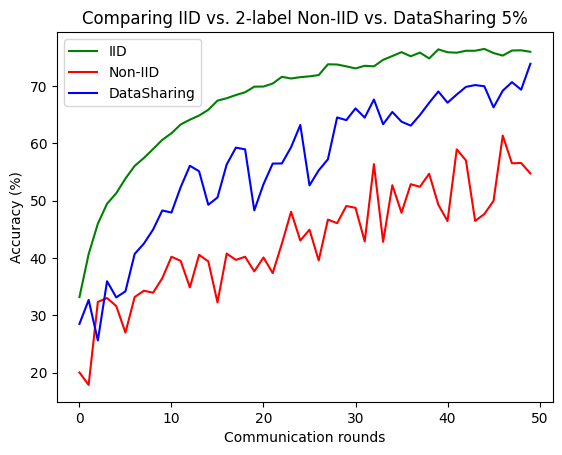

In [12]:
plt.plot(np.array(run_accuracy_1)*100, 'g-')
plt.plot(np.array(run_accuracy_2)*100, 'r-')
plt.plot(np.array(run_accuracy_3)*100, 'b-')
plt.xlabel('Communication rounds')
plt.ylabel('Accuracy (%)')
plt.title('Comparing IID vs. 2-label Non-IID vs. DataSharing 5%')
plt.legend(['IID', 'Non-IID', 'DataSharing'])
plt.show()

# Concluding remarks

From the above graph, we can see that when each client only has 2-labels during training, then it does far worse than in the IID setting. We see a difference of about 20% in accuracy. However, when datasharing 5% of the global set, we see a significant increase in accuracy where the non-iid + datasharing does almost as well as the IID experiemnt.